In [1]:
from pathlib import Path
import pickle

import librosa
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, scale
from sklearn.metrics import roc_auc_score, mean_absolute_error, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, GlobalAveragePooling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from extract_spectrogram import spectrogram, compute_mfcc


In [2]:
compute_features = True
wav_data_path = "data/genres_wav"
np_data_path = "data/genres_np"

In [3]:
def evaluate(model, X_test, y_test, labels):
    
    print(pd.Series(model.evaluate(X_test, y_test), index=model.metrics_names))
        
    plt.figure(figsize=(12,8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    
    probabilities = model.predict(X_test)
    predictedClasses = np.argmax(probabilities, axis=1)
    confMat = pd.DataFrame(confusion_matrix(y_test, predictedClasses), index=labels, columns=labels)
    confMat /= np.sum(confMat, axis=1)

    plt.figure(figsize=(12,8))
    sns.heatmap(confMat, cmap=plt.cm.Blues, annot=True)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion matrix')

# CNN on the spectrogram images

In [4]:
folder = Path(wav_data_path)

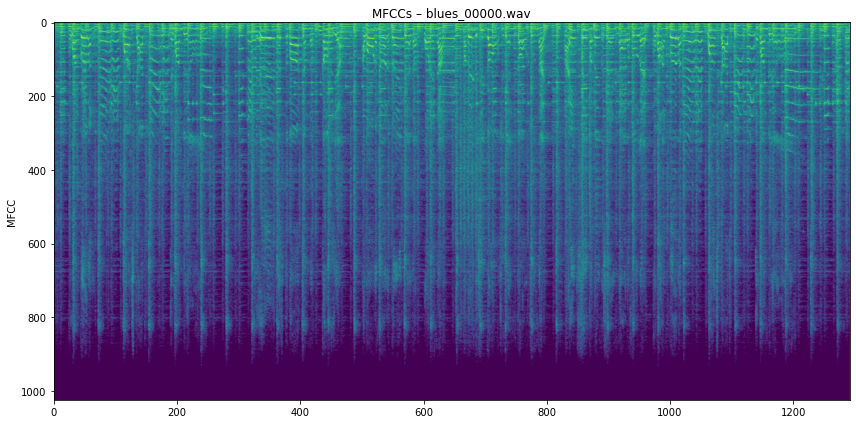

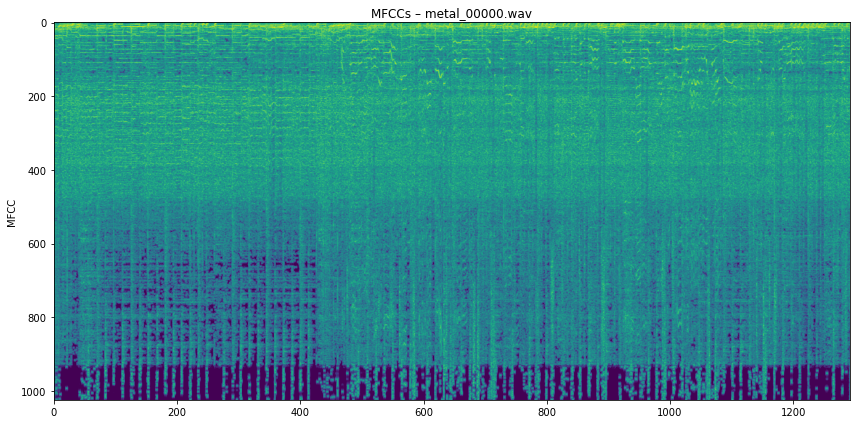

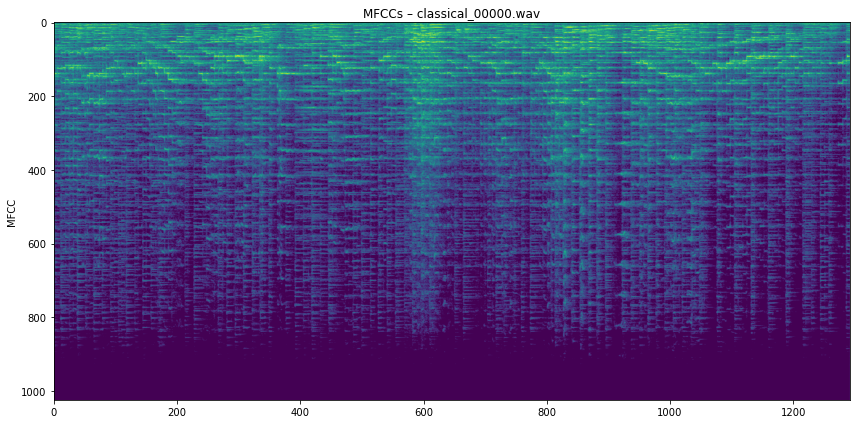

In [6]:
for path in [Path(folder, "blues_00000.wav"), Path(folder, "metal_00000.wav"), Path(folder, "classical_00000.wav")]:
    example_mfcc = spectrogram(path)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(example_mfcc, aspect="auto")
    ax.set(title=f'MFCCs – {path.name}', ylabel='MFCC')
    plt.tight_layout()

In [5]:
if compute_features:
    
    # Load the wav files
    dataset = np.array([spectrogram(path) for path in folder.glob("*.wav")])
    n, img_rows, img_cols = dataset.shape
    dataset = dataset.reshape(n, img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    print('data shape: {}'.format(dataset.shape))
    print('input shape: {}'.format(input_shape))

    # Get the targets
    targets = np.array([path.stem.split("_")[0] for path in  folder.glob("*.wav")])
    labels = np.unique(targets)
    nr_classes = len(labels)

    # categorize the target
    targets = LabelEncoder().fit_transform(targets)
    #targets = to_categorical(targets, num_classes=nr_classes)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(dataset, targets, test_size=0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

    np.save(Path(np_data_path, "x_train.npy"), X_train)
    np.save(Path(np_data_path, "y_train.npy"), y_train)
    np.save(Path(np_data_path, "x_test.npy"), X_test)
    np.save(Path(np_data_path, "y_test.npy"), y_test)
    np.save(Path(np_data_path, "x_val.npy"), X_val)
    np.save(Path(np_data_path, "y_val.npy"), y_val)

else:
    X_train = np.load(Path(np_data_path, "x_train.npy"))
    y_train = np.load(Path(np_data_path, "y_train.npy"))
    X_test = np.load(Path(np_data_path, "x_test.npy"))
    y_test = np.load(Path(np_data_path, "y_test.npy"))
    X_val = np.load(Path(np_data_path, "x_val.npy"))
    y_val = np.load(Path(np_data_path, "y_val.npy"))
      
print(f"Train data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Test data: {X_test.shape}, {y_test.shape}")

data shape: (999, 1025, 1292, 1)
input shape: (1025, 1292, 1)
Train data: (799, 1025, 1292, 1), (799,)
Validation data: (100, 1025, 1292, 1), (100,)
Test data: (100, 1025, 1292, 1), (100,)


In [6]:
# NN architecture
filters = 16
nr_layers = 2

input_layer = Input(input_shape)
x = Conv2D(filters=filters, kernel_size=(3, 3), activation="relu", padding="same")(input_layer)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Dropout(.2)(x)
for _ in range(nr_layers):
    filters *= 2
    x = Conv2D(filters=filters, kernel_size=(3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Dropout(.2)(x)

#x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
output_layer = Dense(nr_classes, activation="softmax")(x)

model = Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1025, 1292, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, 1025, 1292, 16)    160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 513, 646, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 513, 646, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 513, 646, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 257, 323, 32)     0         
 2D)                                                         

In [7]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor="val_loss")
early_stopping = EarlyStopping(monitor="loss", patience=3)
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'model/dropout/dropout/Mul' defined at (most recent call last):
    File "C:\Users\bapti\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\bapti\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\bapti\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\bapti\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\bapti\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\bapti\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\bapti\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\bapti\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\bapti\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\bapti\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\bapti\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\bapti\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\bapti\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\bapti\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\bapti\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\bapti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\bapti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\bapti\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\bapti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\bapti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\bapti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\bapti\AppData\Local\Temp/ipykernel_41324/1434074204.py", line 4, in <module>
      history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val),
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\layers\core\dropout.py", line 111, in call
      output = control_flow_util.smart_cond(training, dropped_inputs,
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\layers\core\dropout.py", line 108, in dropped_inputs
      return self._random_generator.dropout(
    File "C:\Users\bapti\anaconda3\lib\site-packages\keras\backend.py", line 1940, in dropout
      return tf.nn.dropout(inputs, rate=rate, noise_shape=noise_shape,
Node: 'model/dropout/dropout/Mul'
OOM when allocating tensor with shape[32,513,646,16] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/dropout/dropout/Mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_979]

4/4 [==============================] - 13s 212ms/step - loss: 236.4185 - accuracy: 0.1200
loss        236.418472
accuracy      0.120000
dtype: float64


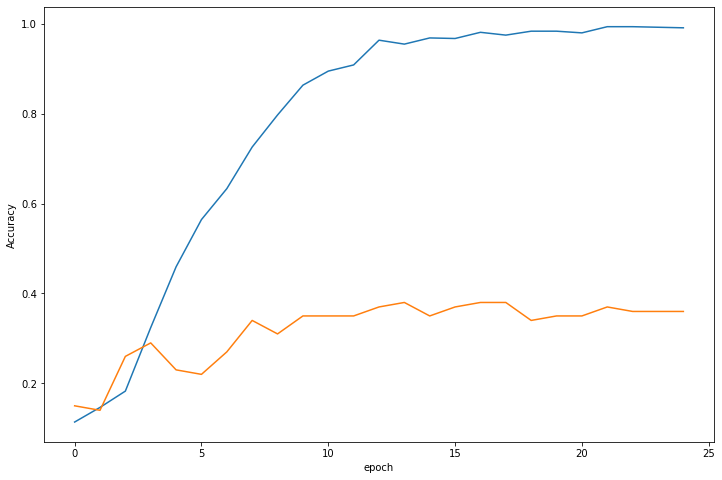

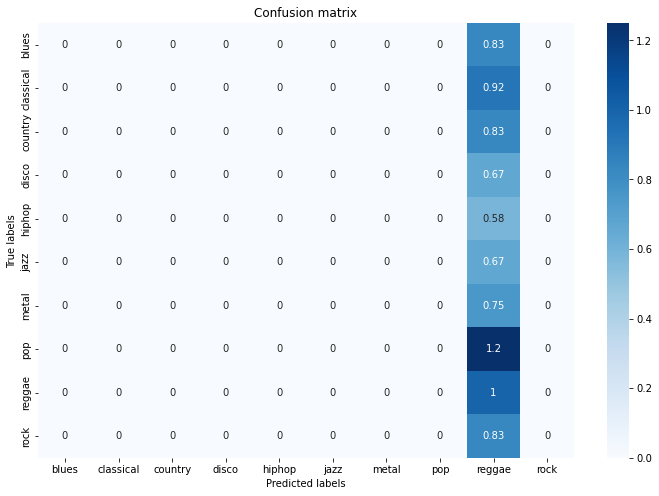

In [21]:
evaluate(model, X_test, y_test, labels)

# Resnet-like

In [30]:
def conv_block(x, filters, activation=None):
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
    return x

In [40]:
filters = 32
nr_layers = 1

input_layer = Input(input_shape)
x = conv_block(x=input_layer, filters=filters, activation="relu")
filters *= 2

x = conv_block(x=x, filters=filters, activation="relu")
filters *= 2

previous_block_activation = x  # Set aside residual

for _ in range(nr_layers):
    x = conv_block(x=x, filters=filters, activation="relu")
    x = conv_block(x=x, filters=filters, activation=None)
    x = MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
    x = add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual
    x = Activation("relu")(x)
    filters *= 2

x = conv_block(x=x, filters=filters, activation="relu")
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

output_layer = Dense(nr_classes, activation="softmax")(x)
model = Model(input_layer, output_layer)
model.summary()
#plot_model(model)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 1292,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_62 (Conv2D)             (None, 128, 1292, 3  320         ['input_17[0][0]']               
                                2)                                                                
                                                                                                  
 batch_normalization_30 (BatchN  (None, 128, 1292, 3  128        ['conv2d_62[0][0]']              
 ormalization)                  2)                                                         

In [41]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor="val_loss")
early_stopping = EarlyStopping(monitor="loss", patience=3)
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/5


Error: Canceled future for execute_request message before replies were done

In [ ]:
evaluate(model, X_test, y_test, labels)